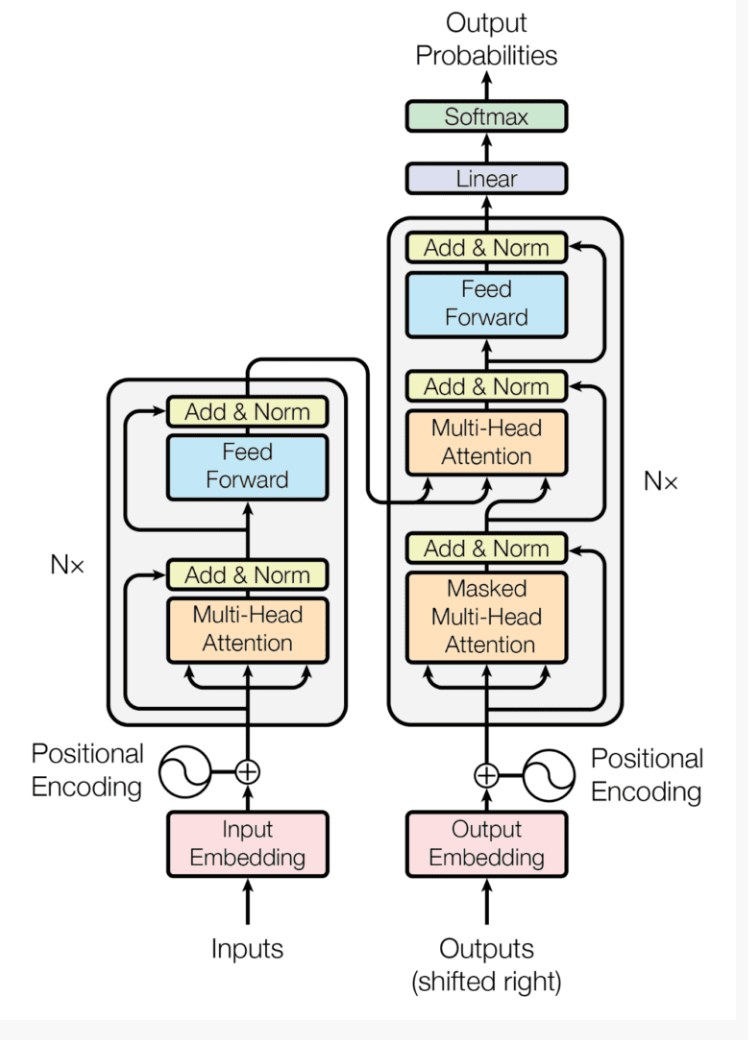

In [1]:
import torch
from torch import nn
import math
import torch.nn.functional as F

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()

        # Self-attention
        self.attention1 = nn.MultiheadAttention(d_model, n_head, dropout=drop_prob, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(drop_prob)

        # Cross-attention
        self.cross_attention = nn.MultiheadAttention(d_model, n_head, dropout=drop_prob, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(drop_prob)

        # Feed-forward network
        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden, drop_prob)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(drop_prob)

    def forward(self, dec, enc, t_mask, s_mask):
        # Self-attention with residual connection
        _x = dec
        x, _ = self.attention1(dec, dec, dec, attn_mask=t_mask)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Cross-attention with residual connection
        _x = x
        x, _ = self.cross_attention(x, enc, enc, attn_mask=s_mask)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        # Feed-forward with residual connection
        _x = x
        x = self.ffn(x)
        x = self.dropout3(x)
        x = self.norm3(x + _x)

        return x


class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layer, drop_prob, device='cpu'):
        super(Decoder, self).__init__()

        # Embedding layer: vocab_size -> d_model
        self.embedding = nn.Embedding(dec_voc_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len, drop_prob, device)

        # Stack of Decoder layers (no device parameter)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, ffn_hidden, n_head, drop_prob)
            for _ in range(n_layer)
        ])

        # Final linear layer to project to vocabulary
        self.fc = nn.Linear(d_model, dec_voc_size)

    def forward(self, dec, enc, t_mask, s_mask):
        # Apply embedding and positional encoding
        dec = self.embedding(dec)
        dec = self.pos_encoding(dec)

        # Pass through decoder layers
        for layer in self.layers:
            dec = layer(dec, enc, t_mask, s_mask)

        # Project to vocabulary size
        dec = self.fc(dec)

        return dec